# Deep drawing 3D shape prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import os
import sys
sys.path.insert(0, "../../src")
from cut_predictor import ProjectionPredictor

## Load the pretrained network

In [2]:
reg = ProjectionPredictor()
reg.load_config('../../models/springback_uvmap_xyz.pkl')
reg.load_network('../../models/best_uv_xyz_model/')

A nicer visualization method with plotly, a faster one with matplotlib

In [51]:
reg.min_values

{'Blechdicke': 0.99,
 'Niederhalterkraft': 10,
 'Einlegeposition': -5,
 'Rp0': 133.18263199999998,
 'u': 0.0,
 'v': 0.0,
 'x': -202.42731,
 'y': -118.32256,
 'z': 0.0}

In [3]:
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 110.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 30,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }

In [4]:
df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": .5})
dfr = reg.predict(param, df)
dfr

1/1 [==============================] - 0s 153ms/step


,v,u,x,y,z
0,0.000000,0.5,0.014267,-94.826859,2.014291
1,0.010101,0.5,-0.012421,-90.853508,2.028922
2,0.020202,0.5,-0.249634,-86.664955,2.101868
3,0.030303,0.5,-0.327362,-82.322403,2.168966
4,0.040404,0.5,-0.547134,-78.078232,2.160779
...,...,...,...,...,...
95,0.959596,0.5,1.520844,79.650749,2.368178
96,0.969697,0.5,1.617126,83.992760,2.605947
97,0.979798,0.5,1.627792,88.214928,2.876570
98,0.989899,0.5,1.683853,92.448250,3.229417


1/1 [==============================] - 0s 13ms/step


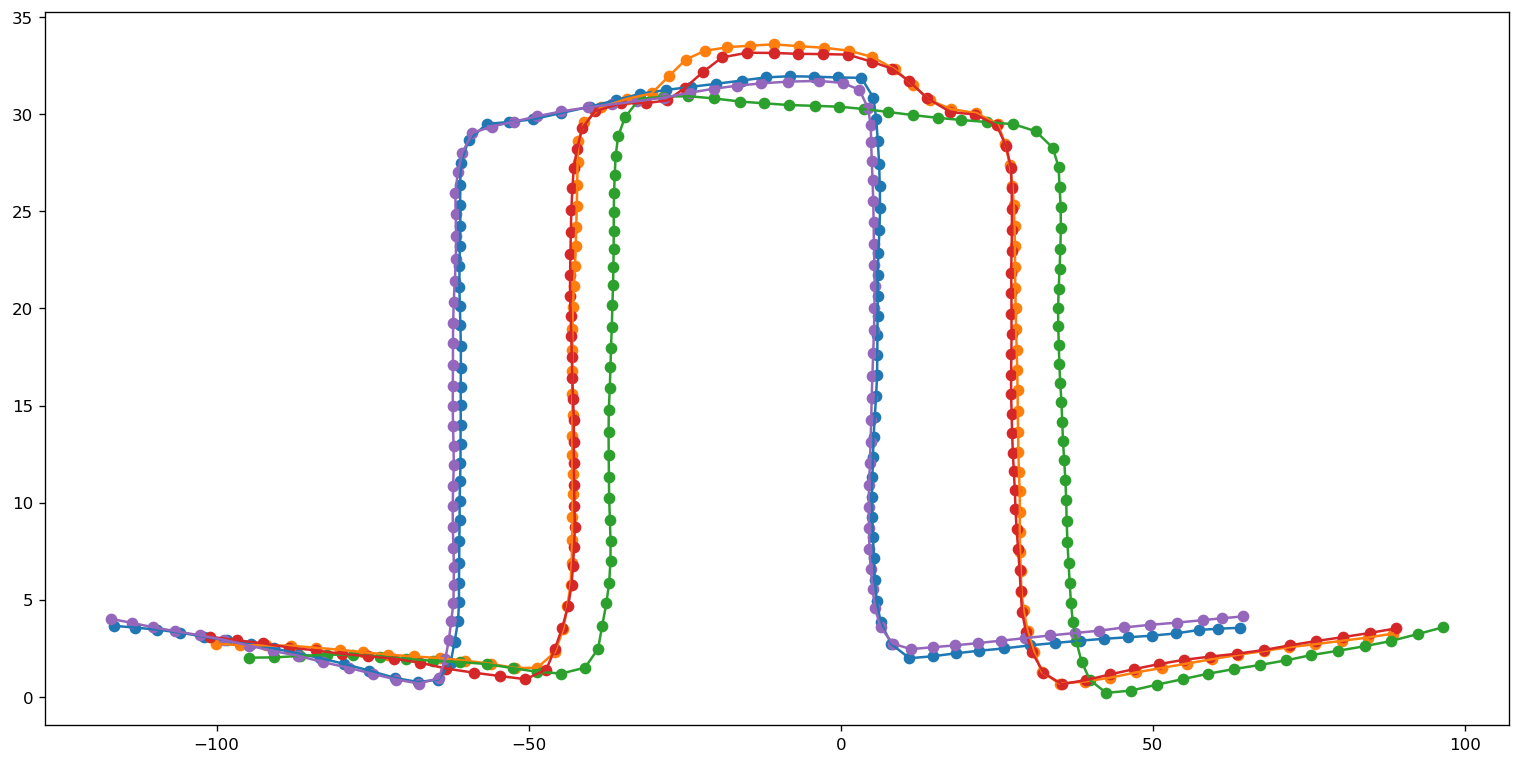

In [5]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
for u in np.linspace(0.,1,5):
    df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": u})
    dfr = reg.predict(param, df)
    ax.scatter(dfr.y, dfr.z)
    ax.plot(dfr.y, dfr.z)

In [6]:
import scale.fem.lsdyna.api as api
mesh2d = api.BoxMesh2d(size=[1,1,0], elsize=.01, pid=1)
mesh2d.gen_box()
mesh2d.info()
mesh2d.fix_column_types()
mesh2d.nodes.dtypes

nid      int64
x      float64
y      float64
z      float64
dtype: object

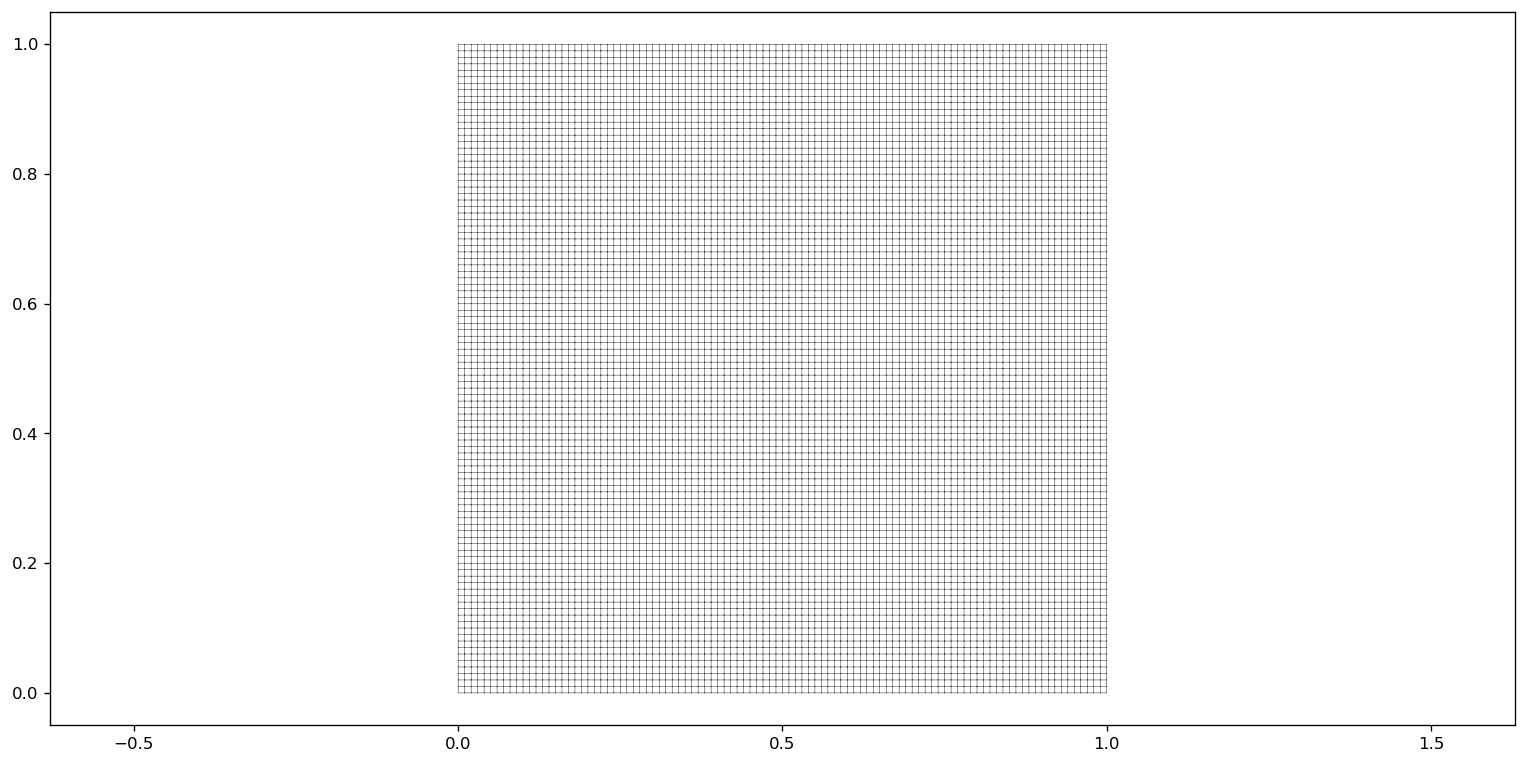

In [7]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
ax.set_aspect("equal", "datalim")
mesh2d.plot_mpl(ax=ax)


In [22]:
mesh = mesh2d.copy()
mesh.nodes = mesh.nodes.rename(columns={"x":"u", "y":"v", "z":"w"})
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 410.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 50,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }
mesh.nodes = reg.predict(param, mesh.nodes)
mesh.nodes

3/3 [==============================] - 0s 15ms/step


,nid,u,v,w,x,y,z
1,1,0.00,0.0,0.0,-127.515381,-115.984497,2.608392
2,2,0.01,0.0,0.0,-125.580147,-115.444351,2.571399
3,3,0.02,0.0,0.0,-123.524666,-114.850845,2.523549
4,4,0.03,0.0,0.0,-121.222198,-114.224045,2.468492
5,5,0.04,0.0,0.0,-118.869934,-113.640129,2.406066
...,...,...,...,...,...,...,...
10197,10197,0.96,1.0,0.0,172.787933,71.149071,2.988327
10198,10198,0.97,1.0,0.0,176.542480,70.061180,3.062447
10199,10199,0.98,1.0,0.0,180.490814,69.010262,3.158413
10200,10200,0.99,1.0,0.0,184.580292,68.033211,3.245968


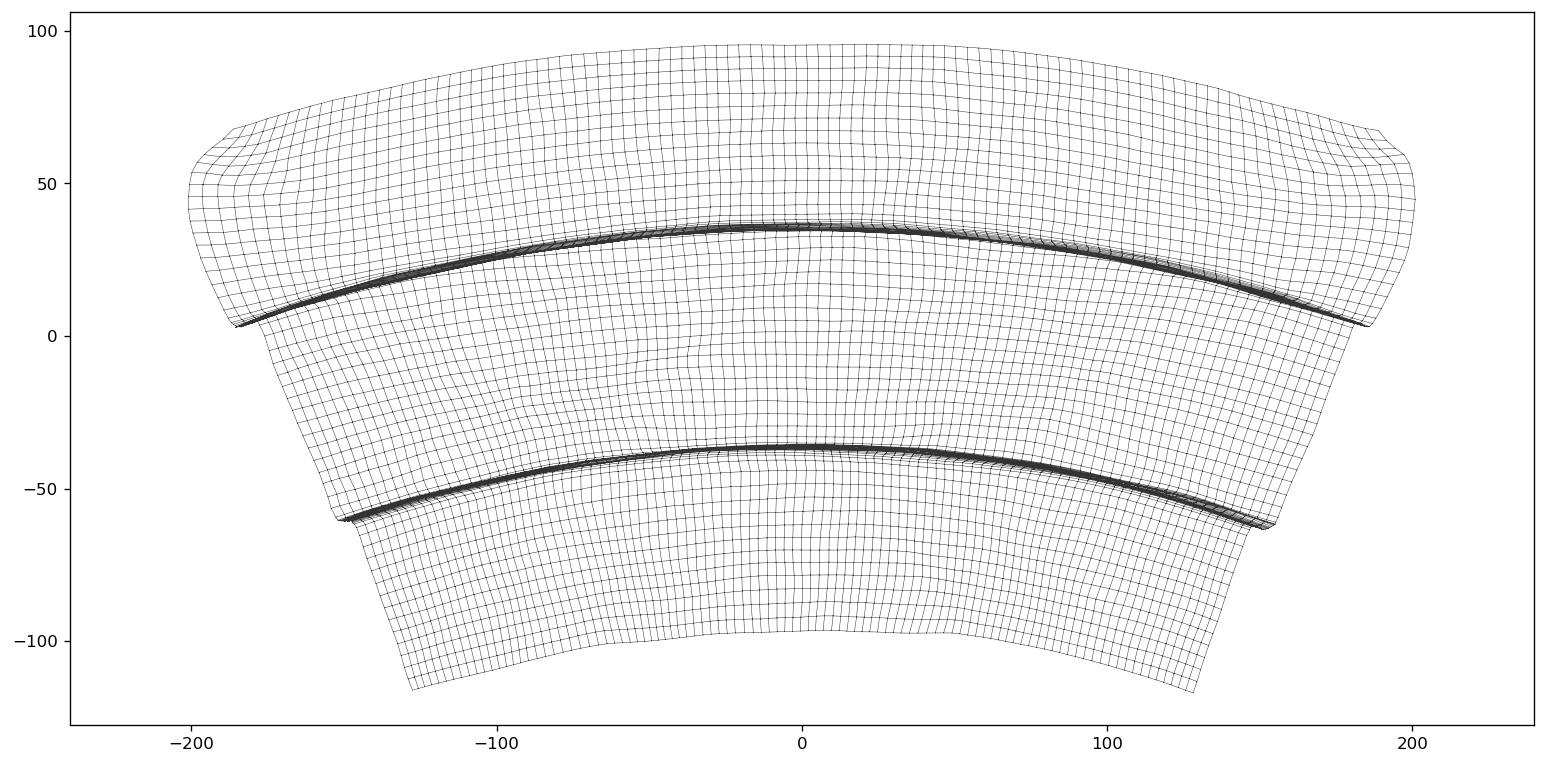

In [23]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
ax.set_aspect("equal", "datalim")
mesh.plot_mpl(ax=ax)

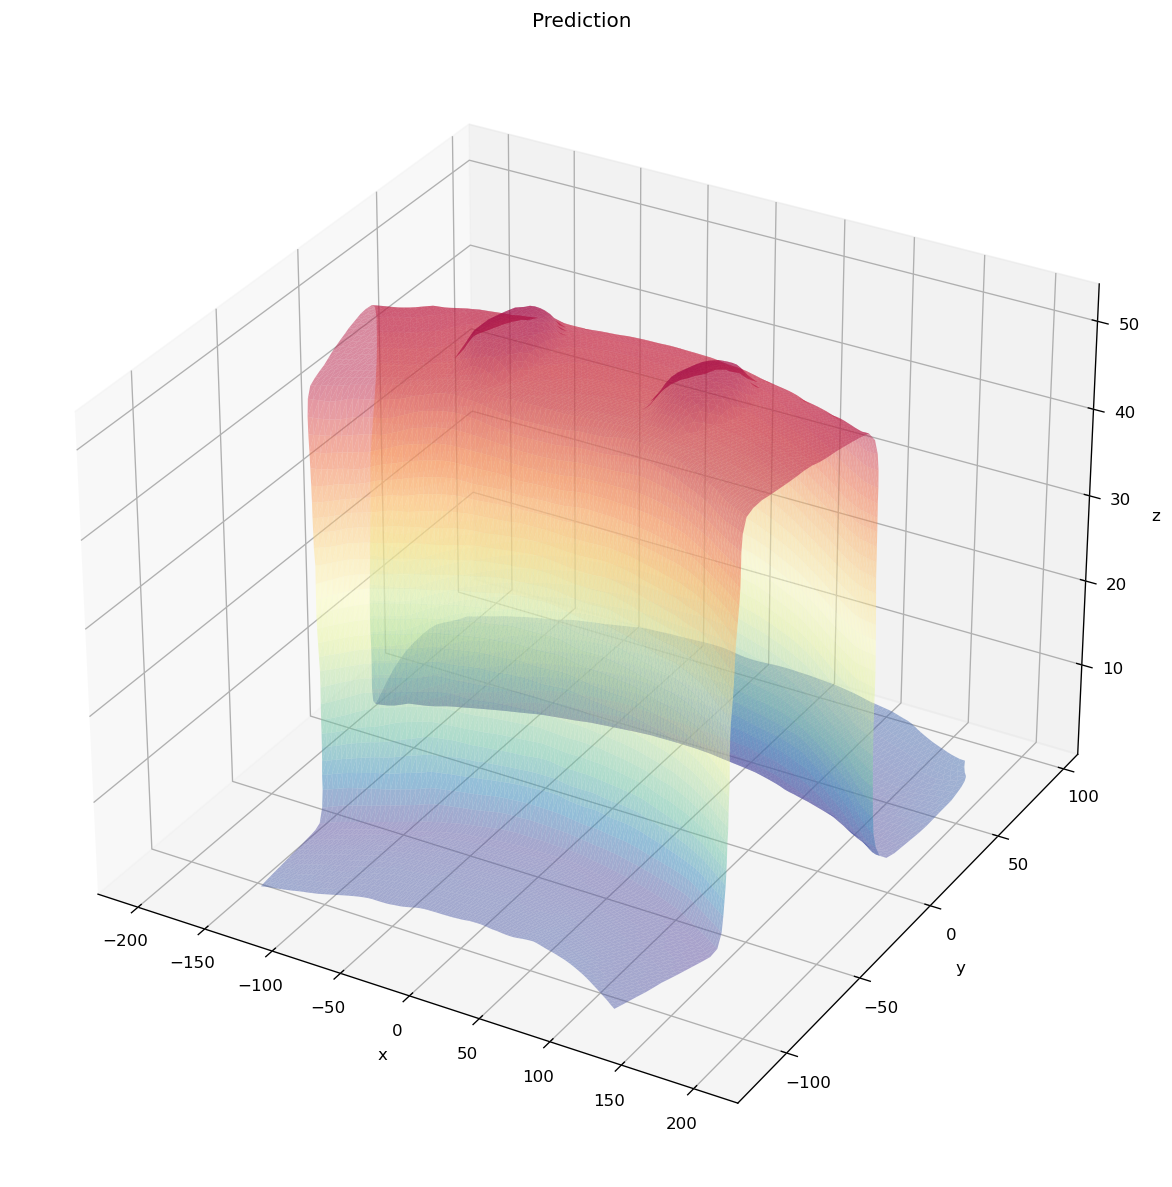

In [24]:
mesht = api.TriaMesh.from_mesh(mesh)
fig = plt.figure(1, figsize=(18,10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(mesht.nodes.x, mesht.nodes.y, mesht.nodes.z, 
                triangles=mesht.simplices(), cmap=plt.cm.Spectral_r, 
                alpha=.5, shade=False)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Prediction")
fig.tight_layout()

In [25]:
mesh.show_in()


 _____________________________________________________
 |                                                   |
 |     Livermore Software Technology Corporation     |
 |                                                   |
 |                L S - P R E P O S T                |
 |                                                   |
 |    Advanced Pre- and Post-Processor for LS-DYNA   |
 |                                                   |
 |       LS-PrePost(R) V4.8(Beta) - 30Jun2020        |
 |                                                   |
 |            LSTC Copyright (C) 1999-2019           |
 |                All Rights Reserved                |
 |___________________________________________________|

 OpenGL version 4.6.0 NVIDIA 510.47.03
Time to read keyword file = 0.306 seconds
Time to process element data = 0.018 seconds

 _____________________________________________________
 |                                                   |
 |     Livermore Software Technology Corporati

In [33]:
reg.model

In [28]:
reg.model.save("my_h5_model.h5")


In [31]:
import keras
reconstructed_model = keras.models.load_model("my_h5_model.h5")
reconstructed_model

In [49]:
from tensorflow.python.keras.saving import hdf5_format
import h5py


model_path = "/tmp/a.h5"
my_keras_model = reg.model

# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(my_keras_model, f)
    f.attrs['param1'] = reg.process_parameters
    f.attrs['param2'] = 3

# Load model
with h5py.File(model_path, mode='r') as f:
    param1 = f.attrs['param1']
    param2 = f.attrs['param2']
    my_keras_model = hdf5_format.load_model_from_hdf5(f)
param1

array(['Blechdicke', 'Niederhalterkraft', 'Ziehspalt', 'Einlegeposition',
       'Ziehtiefe', 'Rp0'], dtype=object)

In [41]:
#reg.model.to_json()

In [36]:
json_config = reg.model.to_json()
new_model = keras.models.model_from_json(json_config)
new_model

In [40]:
reg.model.save_weights("w.h5")

TypeError: save_weights() missing 1 required positional argument: 'filepath'